# NumPy Neural Networks
## Zachary Neveu

# Contents and why we need this lab

This lab is about implementing neural networks yourself in NumPy before we start using other frameworks which hide some of the computation from you. It builds on the first lab where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution. If you already know how to program most things about Python and NumPy can be found through Google search. 


# This notebook will follow the next steps:

1. Data generation
2. Initialization of parameters
3. Definition of activation functions   
4. A short explanation of numpy's einsum function
5. Forward pass
6. Backward pass (backward pass and finite differences)
7. Training loop 
8. Testing your model
9. Further extensions

# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator has support various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [26]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [27]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    """
    Generates normally distributed data with some correlation
    """
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [28]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

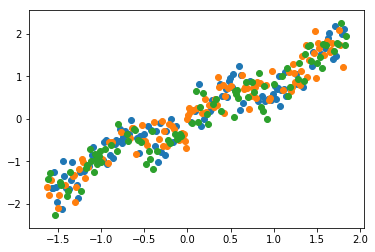

In [29]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);

# Initialization

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. We are going to save these numbers in a list "L" that is going to start with our input dimensionality (the number of features in X) and is going to finish with our output dimensionality (the size of Y). Anything in between these values are going to be hidden layers and the number of hidden units in each hidden layer is defined by the researcher. Remember that for each unit in each layer (besides the first one, according to our list L) there is a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

Our initialization will work as follows: 

For each layer of the neural network defined in L, initialize a matrix of weights of size (units_in, units_out) from a random normal distribution [np.random.normal()](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html) and save them in a list called "layers". For each layer in our neural network, initialize a matrix of weights of size (1, units_out) as above and save them in a list called "bias". The function should return a tuple (layers, bias). The length of our lists must be len(L)-1.

In [30]:
# Initialize neural network:
# the NN is a tuple with a list with weights and list with biases
def init_NN(L):
    """
    Function that initializes our feed-forward neural network. 
    Input: 
    L: list of integers. The first element must be equal to the number of features of x and the last element 
        must be the number of outputs in the network.
    Output:
    A tuple of:
    weights: a list with randomly initialized weights of shape (in units, out units) each. The units are the ones we defined in L.
        For example, if L = [2, 3, 4] layers must be a list with a first element of shape (2, 3) and a second elemtn of shape (3, 4). 
        The length of layers must be len(L)-1
    biases: a list with randomly initialized biases of shape (1, out_units) each. For the example above, bias would be a list of length
        2 with a first element of shape (1, 3) and a second element of shape (1, 4).
    """
    weights = []
    biases  = []
    for i in range(len(L)-1):
        weights.append(np.random.normal(loc=0.0, scale=1.0, size=[L[i],L[i+1]])) 
        biases.append(np.random.normal(loc=0.0, scale=1.0, size=[1, L[i+1]]))     
        
    return (weights, biases)

# Initialize the unit test neural network:
# Same steps as above but we will not initialize the weights randomly.
def init_NN_UT(L):
    weights = []
    biases  = []
    for i in range(len(L)-1):
        weights.append(np.ones((L[i],L[i+1]))) 
        biases.append(np.ones((1, L[i+1])))     
        
    return (weights, biases)

# Initializer the unit test neural network
L_UT  = [3, 5, 1]
NN_UT = init_NN_UT(L_UT)

## Exercise a) Print all network parameters

Make a function that prints all parameters (weights and biases) with information about in which layer the parameters are.

In [31]:
def print_params(nn):
    for i,w in enumerate(nn[0]):
        b = nn[1][i]
        print(f'\n### Layer {i} ###')
        print(f'Size: {len(w)}-{len(b[0])}')
        print(f'weights: {w}')
        print(f'biases: {b}')

print_params(NN_UT)


### Layer 0 ###
Size: 3-5
weights: [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
biases: [[1. 1. 1. 1. 1.]]

### Layer 1 ###
Size: 5-1
weights: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
biases: [[1.]]


# Advanced initialization schemes

If we are not careful with initialization we can run into trouble with in both the forward and backward passes. We have random weights with random +/- sign so the signal we pass forward will also be random and zero on average. However, the absolute size of the signal may grow or shrink from layer to layer depending upon the absolute scale of random weights. A statistical analysis of this effect and the same effect for the backward pass are presented in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept constant when propagating layer to layer. The exact expressions depend upon the activation function used.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

In the linked paper, Glorot and Bengio propose that for tanh activation functions the following two alternative initializations:

$$w_{ij} \sim U \bigg[ -\sqrt{\frac{6}{(n_{in} + n_{out})}}, \, \sqrt{\frac{6}{(n_{in} + n_{out})}} \bigg]$$

$$w_{ij} \sim N \bigg( 0, \, \frac{2}{(n_{in} + n_{out})} \bigg) \ . $$

Here $U[a,b]$ is a uniform distribution in the interval $a$ to $b$ and $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$.

He et.al. proposes for Rectified Linear Unit activations (ReLU) the following initialization:

$$w_{ij} \sim U \bigg[ -\sqrt{\frac{6}{n_{in}}}, \, \sqrt{\frac{6}{n_{in}}} \bigg]$$

$$w_{ij} \sim N \bigg( 0, \, \frac{2}{n_{in}} \bigg) \ . $$

## Exercise b) Glorot and He initialization

Implement these initialization schemes by modifying the code given below.

**NOTE:** The Gaussian is defined as $N( \mu, \, \sigma^{2})$ but Numpy takes $\sigma$ as argument.

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

### Explanation
To test the initialization schemes, it would suffice to supply a plot with the layers across the access, and the mean/standard deviation of the activation values shown as dots and bars on the y axis. An example of this kind of plot is shown in the Glorot paper and appended here.

![Example Plot from Glorot Paper](./glorot_plot.png)

In [32]:
def plot_weights(nn):
    x = []
    y = []
    e = []
    for i,w in enumerate(nn[0]):
        b = nn[1][i]
        x.append(i)
        y.append(np.mean([np.mean(i) for i in [w, b]]))
        e.append(np.std([np.std(i) for i in [w, b]]))
    print(x)
    print(y)
    print(e)
    plt.errorbar(x, y, yerr=e, fmt='o')

[0, 1]
[1.0, 1.0]
[0.0, 0.0]


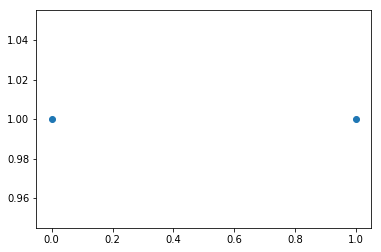

In [33]:
plot_weights(NN_UT)

[0, 1, 2]
[-0.04102599684586049, -0.25909609957822083, 0.06835906842374084]
[0.03929934732541002, 0.1393382370134931, 0.38062490825550027]


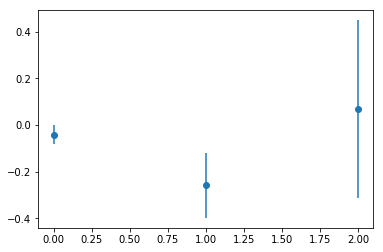

In [34]:
plot_weights(init_NN([5, 4, 3, 2]))

In [35]:
## Glorot
def init_NN_glorot_Tanh(L, uniform=False):
    """
    Initializer using the glorot initialization scheme
    """
    weights = []
    biases  = []
    for i in range(len(L)-1):
        nin = L[i]
        nout = L[i+1]
        # print(f'nin: {nin}, nout {nout}')
        if uniform:
            bound = np.sqrt(6 / (nin+nout))
            weights.append(np.random.uniform(low=-bound, high=bound, size=[L[i],L[i+1]])) 
            biases.append(np.random.uniform(low=-bound, high=bound, size=[1, L[i+1]]))  
        else:
            std = np.sqrt(2 / (nin+nout))
            weights.append(np.random.normal(loc=0.0, scale=std, size=[L[i],L[i+1]])) 
            biases.append(np.random.normal(loc=0.0, scale=std, size=[1, L[i+1]]))       
        
    return (weights, biases)

## He
def init_NN_he_ReLU(L, uniform=False):
    """
    Initializer using the He initialization scheme
    """
    weights = []
    biases  = []
    for i in range(len(L)-1):
        nin = L[i]
        nout = L[i+1]
        if uniform:
            bound = np.sqrt(6 / nin)
            # bound = 1.0 # <- replace with proper initialization
            weights.append(np.random.uniform(low=-bound, high=bound, size=[L[i],L[i+1]])) 
            biases.append(np.random.uniform(low=-bound, high=bound, size=[1, L[i+1]]))  
        else:
            std = np.sqrt(2 / nin)
            # std = 1.0 # <- replace with proper initialization
            weights.append(np.random.normal(loc=0.0, scale=std, size=[L[i],L[i+1]])) 
            biases.append(np.random.normal(loc=0.0, scale=std, size=[1, L[i+1]]))       
        
    return (weights, biases)

[0, 1, 2, 3]
[-0.05492530126840715, 0.18675657194380657, -0.13234735152389637, -0.15954355808881437]
[0.1789257361081587, 0.0648479871265083, 0.16665405833572203, 0.16264415400663887]


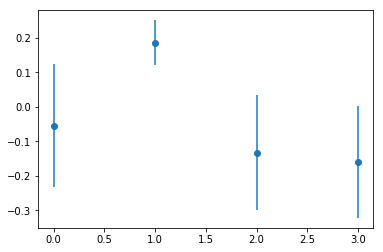

In [36]:
plot_weights(init_NN_glorot_Tanh([5, 4, 3, 2, 1], uniform=False))

[0, 1, 2, 3]
[0.08143727181669938, 0.12357428901041553, 0.29201450978321186, 0.8951476502572643]
[0.006891315953772681, 0.0007423122947111116, 0.1487901262192649, 0.19559058803021478]


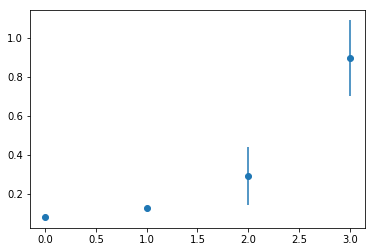

In [37]:
plot_weights(init_NN_he_ReLU([5, 4, 3, 2, 1], uniform=True))

# Activation functions

To have a full definition of the neural network, we must define an activation function for every layer in our list L (again, exluding the first term, which is the number of input dimensions). Several activation functions have been proposed and have different characteristics. Here, we will implement the linear activation function (the identity function), the sigmoid activation function (squeeshes the outcome of each neuron into the $[0, 1]$ range), the Hyperbolic Tangent (Tanh) that squeeshes the outcome of each neuron to $[-1, 1]$ and the Rectified Linear Unit (ReLU). 

We will also include the derivative in the function. We need this in order to do our back-propagation algorithm. Don't rush, we will get there soon. For any neural network, save the activation functions in a list. This list must be of size len(L)-1.

## Linear activation

In [38]:
def Linear(x, derivative=False):
    """
    Computes the element-wise Linear activation function for an array x
    inputs:
    x: The array where the function is applied
    derivative: if set to True will return the derivative instead of the forward pass
    """
    
    if derivative:              # Return the derivative of the function evaluated at x
        return np.ones_like(x)
    else:                       # Return the forward pass of the function at x
        return x

## Sigmoid activation

In [39]:
def Sigmoid(x, derivative=False):
    """
    Computes the element-wise Sigmoid activation function for an array x
    inputs:
    x: The array where the function is applied
    derivative: if set to True will return the derivative instead of the forward pass
    """
    f = 1/(1+np.exp(-x))
    
    if derivative:              # Return the derivative of the function evaluated at x
        return f*(1-f)
    else:                       # Return the forward pass of the function at x
        return f

## Hyperbolic Tangent activation

In [40]:
def Tanh(x, derivative=False):
    """
    Computes the element-wise Sigmoid activation function for an array x
    inputs:
    x: The array where the function is applied
    derivative: if set to True will return the derivative instead of the forward pass
    """
    f = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    
    if derivative:              # Return the derivative of the function evaluated at x
        return 1-f**2
    else:                       # Return the forward pass of the function at x
        return f

## Rectifier linear unit (ReLU)

In [41]:
def ReLU(x, derivative=False):
    """
    Computes the element-wise Rectifier Linear Unit activation function for an array x
    inputs:
    x: The array where the function is applied
    derivative: if set to True will return the derivative instead of the forward pass
    """
    
    if derivative:              # Return the derivative of the function evaluated at x
        return (x>0).astype(int)
    else:                       # Return the forward pass of the function at x
        return np.maximum(x, 0)

## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

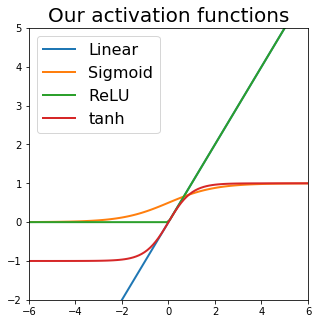

In [42]:
x = np.linspace(-6, 6, 100)
units = {
    "Linear": lambda x: Linear(x),
    "Sigmoid": lambda x: Sigmoid(x),
    "ReLU": lambda x: ReLU(x),
    "tanh": lambda x: Tanh(x)
}

plt.figure(figsize=(5, 5))
[plt.plot(x, unit(x), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

## Exercise c) Glorot initialization for all activation functions

Implement a function by adding to the code snippet below that can take network L and list of activations function as argument and return a Glorot initialized network.  Hint: [This blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init) gives a table for the activation functions we use here.

Briefly explain in words how these how these values are calculated.

In [43]:
def init_NN_Glorot(L, activations, uniform=False):
    """
    Initializer using the glorot initialization scheme
    """
    # Insert code here
    weights = []
    biases  = []
    for i in range(len(L)-1):
        nin = L[i]
        nout = L[i+1]
        # act = activations[i].lower()
        act = activations[i]
        
        # TODO: refactor this to only do basic calculation in one line
        if act == Tanh:
            bound = np.sqrt(6 / (nin+nout))
            std = np.sqrt(2 / (nin+nout))
        elif act == ReLU or act == Linear:
            bound = np.sqrt(2)*np.sqrt(6 / (nin+nout))
            std = np.sqrt(2)*np.sqrt(2 / (nin+nout))
        elif act == Sigmoid:
            bound = 4*np.sqrt(6 / (nin+nout))
            std = 4*np.sqrt(2 / (nin+nout))
            
        if uniform:
            weights.append(np.random.uniform(low=-bound, high=bound, size=[L[i],L[i+1]])) 
            biases.append(np.random.uniform(low=-bound, high=bound, size=[1, L[i+1]]))  
        else:
            weights.append(np.random.normal(loc=0.0, scale=std, size=[L[i],L[i+1]])) 
            biases.append(np.random.normal(loc=0.0, scale=std, size=[1, L[i+1]]))       
    return (weights, biases)
            
            
        

# Initializes the unit test neural network
L_UT  = [3, 5, 1]
ACT_UT = [ReLU, Tanh]
NN_Glorot = init_NN_Glorot(L_UT, ACT_UT)

[0, 1]
[0.1024521212136887, -0.22457178104706033]
[0.09707223801813725, 0.14779235750552952]


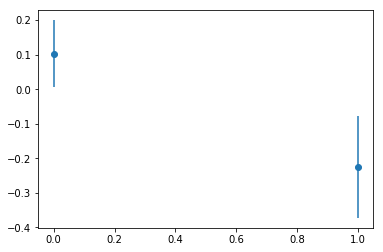

In [44]:
plot_weights(NN_Glorot)

# Numpy einsum (EINstein SUMmation)

[Einsum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html) gives us the possibility to compute almost any matrix operation in a single function. You can find a good description in the link above. Here are a few examples of some important uses:

**Transpose:** We can write the transpose of matrix $A$:

```
np.einsum('ij -> ji', A) 
```

**Trace:** We can write the trace of matrix $A$:

```
np.einsum('ii -> ', A) 
```

**Diagonal:** We can write the diagonal of matrix $A$:

```
np.einsum('ii -> i', A) 
```
 
**Matrix product:** We can write the multiplication of matrices $A$ and $B$ as:

```
np.einsum('ij, jk -> ik', A, B)
```

Note that $j$ in both matrices $A$ and $B$ should be the same size. 

**Batched matrix product (or why bothering):** All of the functions we performed above are built in numpy (np.tranpose, np.trace, np.matmul), however, when you want to do more complex operations, it might become less readable and computationaly efficient. Let's introduce a three dimensional matrix $H$ with indices $b,j,k$, where the first dimension is the batch (training example) dimension. In einsum, we can then write:

```
np.einsum('ij, bjk -> bik', A, H)
```

In order to perform a batched matrix multiplication where we multiple over the second dimension in the first marix and second dimension in the second matrix. The result is a new three dimensional matrix where the first dimension is the first dimension from $H$ and second is the first dimension from $A$ and last dimension the last dimension from $H$. This is a very simple one line (and readable) way to do matrix operations that will be very useful for neural network code. 


#### _**Tips and tricks when using einsum**_

At the beginning, einsum might be a bit difficult to work with. The most important thing to do when using it is keeping track of the dimensions of your input and output matrices. An easy way to keep track of these dimensions is by using some sort of naming convention. Just like in the batched matrix product above we used $b$ to denote the batch dimension. In all the functions of this notebook, we leave some convention of names of indexes for the einsum in the explanation of the functions. We hope you find them useful!

There are some other useful resources to understand numpy.einsum:

* [Olexa Bilaniuk's great blogpost on einsum]( https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/ )
* [Stackoverflow answer to: Understanding NumPy's einsum]( https://stackoverflow.com/q/26089893/8899404 )
* [Jessica Stringham post on einsum]( https://jessicastringham.net/2018/01/01/einsum/ )
* [Slides of einstein summation from oxford]( http://www-astro.physics.ox.ac.uk/~sr/lectures/vectors/lecture10final.pdfc )

# Forward pass

The forward pass has been implemented for you. Please note how we have used einsum to perform the affine tranformation.

In [45]:
def forward_pass(x, NN, activations):
    """
    This function performs a forward pass recursively. It saves lists for both affine transforms of units (z) and activated units (a)
    Input:
    x: The input of the network             (np.array of shape: (batch_size, number_of_features))
    NN: The initialized neural network      (tuple of list of matrices)
    activations: the activations to be used (list of functions, same len as NN)

    Output:
    a: A list of affine transformations, that is, all x*w+b.
    z: A list of activated units (ALL activated units including input and output).
    
    Shapes for the einsum:
    b: batch size
    i: size of the input hidden layer (layer l)
    o: size of the output (layer l+1)
    """
    z = [x]
    a = []
        
    for l in range(len(NN[0])):
        a.append(np.einsum('bi, io -> bo', z[l], NN[0][l]) + NN[1][l])  # The affine transform x*w+b
        z.append(activations[l](a[l]))                                  # The non-linearity    
    
    return a, z

# Forward pass unit test

Below is a piece of code that takes a very particular setting of the network and inputs and test whether it gives the expected results.

In [46]:
len(NN_UT[0])

2

In [47]:
ACT_F_UT = [Linear, Linear]
test_a, test_z = forward_pass(np.array([[1,1,1]]), NN_UT, ACT_F_UT) # input has shape (1, 3) 1 batch, 3 features

# Checking shapes consistency
assert np.all(test_z[0]==np.array([1,1,1])) # Are the input vector and the first units the same?
assert np.all(test_z[1]==test_a[0])         # Are the first affine transformations and hidden units the same?
assert np.all(test_z[2]==test_a[1])         # Are the output units and the affine transformations the same?

# Checking correctnes of values
# First layer, calculate np.sum(np.array([1,1,1])*np.array([1,1,1]))+1 = 4
assert np.all(test_z[1] == 4.)
# Second layer, calculate np.sum(np.array([4,4,4,4,4])*np.array([1,1,1,1,1]))+1 = 21
assert np.all(test_z[2] == 21.)

# Loss functions

In order to perform a backward pass we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [48]:
def squared_error(t, y, derivative=False):
    """
    Computes the squared error function and its derivative 
    Input:
    t:      target (expected output)          (np.array)
    y:      output from forward pass (np.array, must be the same shape as t)
    derivative: whether to return the derivative with respect to y or return the loss (boolean)
    """
    if np.shape(t)!=np.shape(y):
        print("t and y have different shapes")
    if derivative: # Return the derivative of the function
        return (y-t)
    else:
        return 0.5*(y-t)**2

## Exercise d) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$.

In [49]:
def cross_entropy_loss(t, y, derivative=False):
    """
    Computes the cross entropy loss function and its derivative 
    Input:
    t:      target (expected output)          (np.array)
    y:      output from forward pass (np.array, must be the same shape as t)
    derivative: whether to return the derivative with respect to y or return the loss (boolean)
    """
    epsilon = 1e-9
    if len(t) == len(y):
        if derivative:
            return (y-t)
        else:
            return -np.sum(t*np.log(y+epsilon))
    else:
        print("t and y not the same length")

In [50]:
t = np.array([1, 0, 0, 1])
y = np.array([1-i for i in t])

In [51]:
y

array([0, 1, 1, 0])

In [52]:
t

array([1, 0, 0, 1])

In [53]:
cross_entropy_loss(t, y)

41.44653167389282

In [55]:
cross_entropy_loss(t, t)

-2.000000164480742e-09

In [54]:
cross_entropy_loss(t, y, derivative=True)

array([-1,  1,  1, -1])

# Backward pass 

## Exercise e) Complete code for backward pass

Below is a implementation of the backward pass with some lines removed. Insert the missing lines.

In [56]:
def backward_pass(x, t, y, z, a, NN, activations, loss):
    """
    This function performs a backward pass ITERATIVELY. It saves lists all of the derivatives in the process
    
    Input:
    x:           The input used for the batch                (np.array)
    t:           The observed targets                        (np.array, the first dimension must be the same to x)
    y:           The output of the forward_pass of NN for x  (np.array, must have the same shape as t)
    a:           The affine transforms from the forward_pass (np.array)
    z:           The activated units from the forward_pass (np.array)
    activations: The activations to be used                  (list of functions)
    loss:        The loss function to be used                (one function)
    
    Output:
    g_w: A list of gradients for every hidden unit 
    g_b: A list of gradients for every bias
    
    Shapes for the einsum:
    b: batch size
    i: size of the input hidden layer (layer l)
    o: size of the output (layer l+1)
    """
    
    BS = x.shape[0] # Implied batch shape 
    
    # First, let's compute the list of derivatives of z with respect to a 
    d_a = []
    for i in range(len(activations)):
        d_a.append(activations[i](a[i], derivative=True))
    # print(f'D_a: {d_a}')
    
    # Second, let's compute the derivative of the loss function
    t = t.reshape(BS, -1)
    
    d_loss = y-t # <- Insert correct expression here
    
     
    # Third, let's compute the derivative of the biases and the weights
    g_w   = [] # List to save the gradient of the weights
    g_b   = [] # List to save the gradients of the biases

    delta = np.einsum('bo, bo -> bo', d_loss, d_a[-1])# loss shape: (b, o); pre-activation units shape: (b, o) hadamard product

    g_b.append(np.mean(delta, axis=0))
    g_w.append(np.mean(np.einsum('bo, bi -> bio', delta, z[-2]), axis=0)) # delta shape: (b, o), activations shape: (b, h) 

    for l in range(1, len(NN[0])):
        d_C_d_z = np.einsum('bo, io -> bi', delta, NN[0][-l])  # Derivative of the Cost with respect to an activated layer d_C_d_z. 
                                                               #  delta shape: as above; weights shape: (i, o)
                                                               # Delta: d_C_d_z (element-wise mult) derivative of the activation layers
                                                               #  delta shape: as above; d_z shape: (b, i)  
        # print(f'd_a at layer l-1: {d_a[-l-1]}')
        # print(d_C_d_z)
        delta = d_C_d_z*d_a[-l-1]   # <- Insert correct expression 
        # print(f'Delta: {delta}')
                                                                
        g_b.append(np.mean(delta, axis=0)) 
        g_w.append(np.mean(np.einsum('bo, bi -> bio', delta, z[-l-2]), axis=0)) # Derivative of cost with respect to weights in layer l:
                                                                                # delta shape: as above; activations of l-1 shape: (b, i)
    
    return g_b[::-1], g_w[::-1]

# Backward pass unit test

We are going to perform the unit test of the backward pass with a finite difference estimation, make sure to read the description of the function and that you understand it well:

## Exercise f) Test correctness of derivatives with finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to test whether the backpropation implementation is working. In short we will use
$$
\frac{\partial E(w)}{\partial w_{ij}^{(l)}} \approx \frac{E(v)-E(w)}{dw}
$$
for $dw \ll 1$ and $v$ is the same network as $w$ apart from $v_{ij}^{(l)} = w_{ij}^{(l)} + dw$.

As arguments the function should take: some data $x$ and $t$ as in the example above, the network including activations, the indices $i$, $j$, $l$ of the weight we investigate and $dw$ and return the right hand side of the expression above.

_Insert your code in the cell below._


In [79]:
def zach_fd_grad(x, t, NN, ACT_F, i, j, l, dw=1e-9):
    from copy import deepcopy
    
    grads = deepcopy(NN)               
    ew, _ = forward_pass(x, NN, ACT_F) 
    
    for e in range(len(NN)):    # iterate over weights, biases
        NN_copy             = deepcopy(NN)    
        NN_copy[e][l][i,j] += dw
        ev, _       = forward_pass(x, NN_copy, ACT_F)     
        #print((ev[-1]-ew[-1])/dw)
        val = (ev[e][i,j]-ew[e][i,j])/dw 
        grads[e][l][i,j]  = val
    
    return grads[0], grads[1]

In [80]:
zach_fd_grad(x_train, y_train, NN_UT, ACT_F_UT, 0, 0, 1)

([array([[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]), array([[0.],
         [1.],
         [1.],
         [1.],
         [1.]])], [array([[1., 1., 1., 1., 1.]]), array([[1.00000008]])])

Once you have implemented the function you can compare this number with the left hand side computed by the implementation above.

Try for different parameters and different values of $dw$. Scan over a range of $dw$ values. Why does the method break down for really small $dw$?

### Answer
As $dw \to 0$,  the numerical stability of the finite difference method deteriorates. In the limit, $dw$ is 0, and this will lead to a division by zero error. Before this limit, floating point numbers will become less accurate, yielding results that in turn become less and less accurate.

Finite differences gives us gradients without computing gradients explicitly. Why don't we use it in practice then?

## Answer
The finite difference method requires computing multiple different values of a function in order to approximate the gradient. As the number of input dimensions rise, the number of points needed also rises. For high dimensional data, the finite difference method can require calculating hundreds or even thousands of values. Automatic differentiation can calculate exact gradients with far less effort.

Below is reference code that computes the finite differences for all parameters.

In [83]:
def finite_diff_grad(x, NN, ACT_F, epsilon=None):
    """
    Finite differences gradient estimator: https://en.wikipedia.org/wiki/Finite_difference_method
    The idea is that we can approximate the derivative of any function (f) with respect to any argument (w) by evaluating the function at (w+e)
    where (e) is a small number and then computing the following opertion (f(w+e)-f(w))/e . Note that we would need N+1 evaluations of
    the function in order to compute the whole Jacobian (first derivatives matrix) where N is the number of arguments. The "+1" comes from the
    fact that we also need to evaluate the function at the current values of the argument.
    
    Input:
    x:       The point at which we want to evaluate the gradient
    NN:      The tuple that contains the neural network
    ACT_F:   The activation functions in order to perform the forward pass
    epsilon: The size of the difference
    
    Output:
    Two lists, the first one contains the gradients with respect to the weights, the second with respect to the biases
    """
    from copy import deepcopy
    
    if epsilon == None:
        epsilon = np.finfo(np.float32).eps # Machine epsilon for float 32
        
    grads = deepcopy(NN)               # Copy of structure of the weights and biases to save the gradients                        
    test_a, _ = forward_pass(x, NN_UT, ACT_F_UT) # We evaluate f(x)
    
    for e in range(len(NN)):                       # Iterator over elements of the NN:       weights or biases
        for h in range(len(NN[e])):                # Iterator over the layer of the element: layer number
            for r in range(NN[e][h].shape[0]):     # Iterator over                           row number
                for c in range(NN[e][h].shape[1]): # Iterator over                           column number 
                    NN_copy             = deepcopy(NN)    
                    NN_copy[e][h][r,c] += epsilon
                    test_a_eps, _       = forward_pass(x, NN_copy, ACT_F)     # We evaluate f(x+eps)
                    grads[e][h][r,c]    = (test_a_eps[-1]-test_a[-1])/epsilon # Definition of finite differences gradient
    
    return grads[0], grads[1]

In [84]:
### Unit test 

## First lest's compute the backward pass using our own function
# Forward pass
test_a, test_z = forward_pass(np.array([[1,1,1]]), NN_UT, ACT_F_UT)
# Backward pass
test_g_b, test_g_w = backward_pass(np.array([[1,1,1]]), np.array([20]), test_a[-1], test_z, test_a, NN_UT, ACT_F_UT, squared_error)
# Estimation by finite differences
test_fdg_w, test_fdg_b = finite_diff_grad(np.array([[1,1,1]]), NN_UT, ACT_F_UT)

In [85]:
# Test whether the weights and biases are all equal as the ones we estimated using back propagation
for l in range(len(test_g_w)):
    assert np.allclose(test_fdg_w[l], test_g_w[l])
    assert np.allclose(test_fdg_b[l], test_g_b[l])

# Training and validation

We are ready to train some neural networks! Below we give some example initializations and a training loop. Try it out. 

In [86]:
# Initialize an arbitrary neural network
#L  = [3, 16, 1]
L  = [1, 8, 1]
NN = init_NN(L)
#NN = init_NN_glorot(L, uniform=True)
#NN = init_NN_he_ReLU(L, uniform=True)

ACT_F = [ReLU, Linear]
#ACT_F = [Tanh, Linear]

# Recommended hyper-parameters for 1-D: 
# L  = [1, 8, 1]
# EPOCHS = 10000
# BATCH_SIZE = 128 
# LEARN_R = 2.5e-1 for Tanh and LEARN_R = 1e-1 for ReLU

# Recommended hyper-parameters for 3-D: 
# L  = [3, 16, 1] 
# EPOCHS = 10000
# BATCH_SIZE = 128 
# LEARN_R = 5e-2 for ReLU and LEARN_R = 1e-1 for Tanh

### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [87]:
# Initialize training hyperparameters
EPOCHS = 20000
BATCH_SIZE = 128 
LEARN_R = 1e-2 

In [88]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
    # Mini-batch indexes
    idx = np.random.choice(x_train.shape[0], size=BATCH_SIZE)
    # Forward pass
    aff, units = forward_pass(x_train[idx,:], NN, ACT_F)
    # Backward pass
    g_b, g_w = backward_pass(x_train[idx,:], y_train[idx], units[-1], units, aff, NN, ACT_F, squared_error)
    
    # Stochastic gradient descent
    for l in range(len(g_b)):
        NN[0][l] -= LEARN_R*g_w[l]
        NN[1][l] -= LEARN_R*g_b[l]
        
    # Training loss
    _, units = forward_pass(x_train, NN, ACT_F)
    # Estimate loss function
    #print(np.max(squared_error(y_train, units[-1])))
    train_loss.append(np.mean(squared_error(y_train, np.squeeze(units[-1]))))
    
    # Validation
    # Forward pass
    _, units = forward_pass(x_validation, NN, ACT_F)
    # Estimate validation loss function
    val_loss.append(np.mean(squared_error(y_validation, np.squeeze(units[-1]))))
    
    if e%500==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 6.333 	 Validation loss: 4.724
 500 ( 2.50%) Train loss: 0.047 	 Validation loss: 0.042
1000 ( 5.00%) Train loss: 0.044 	 Validation loss: 0.041
1500 ( 7.50%) Train loss: 0.042 	 Validation loss: 0.040
2000 (10.00%) Train loss: 0.040 	 Validation loss: 0.040
2500 (12.50%) Train loss: 0.039 	 Validation loss: 0.040
3000 (15.00%) Train loss: 0.039 	 Validation loss: 0.039
3500 (17.50%) Train loss: 0.038 	 Validation loss: 0.038
4000 (20.00%) Train loss: 0.038 	 Validation loss: 0.038
4500 (22.50%) Train loss: 0.038 	 Validation loss: 0.037
5000 (25.00%) Train loss: 0.037 	 Validation loss: 0.037
5500 (27.50%) Train loss: 0.037 	 Validation loss: 0.037
6000 (30.00%) Train loss: 0.037 	 Validation loss: 0.037
6500 (32.50%) Train loss: 0.037 	 Validation loss: 0.037
7000 (35.00%) Train loss: 0.037 	 Validation loss: 0.037
7500 (37.50%) Train loss: 0.037 	 Validation loss: 0.037
8000 (40.00%) Train loss: 0.037 	 Validation loss: 0.037
8500 (42.50%) Train loss: 0.036

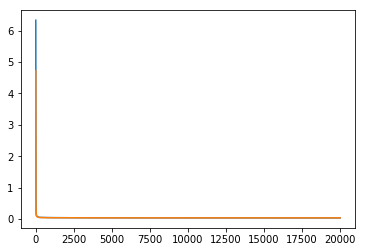

In [89]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [90]:
_, units = forward_pass(x_test, NN, ACT_F)

Test loss:  0.042


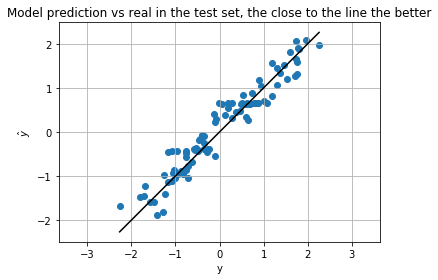

In [91]:
plt.scatter(y_test, units[-1]);
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

print("Test loss:  {:4.3f}".format(np.mean(squared_error(y_test, np.squeeze(units[-1])))))

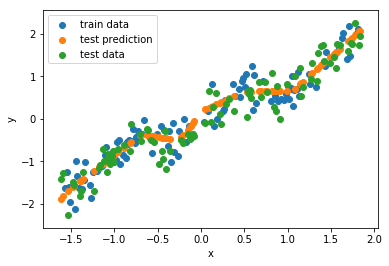

In [92]:
if D1:
    plt.scatter(x_train[:,0], y_train, label="train data");
    plt.scatter(x_test[:,0], units[-1], label="test prediction");
    plt.scatter(x_test[:,0], y_test, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train[:,1], y_train, label="train data");
    plt.scatter(x_test[:,1], units[-1], label="test data prediction");
    plt.scatter(x_test[:,1], y_test, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise g) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

### Answer
For this problem, Validation and Training loss are very close in magnitude. Even when purposefully overfitting, training loss does not drop far below validation loss.

## Note: Learner and Data classes created for code reuse and cleanliness

In [93]:
class Learner:
    def __init__(self, data, L, ACT_F, EPOCHS=2e4, BATCH_SIZE=128, LEARN_R=1e-2):
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.LEARN_R = LEARN_R
        self.ACT_F = ACT_F
        self.NN = init_NN_Glorot(L, ACT_F, uniform=True)
        self.x_train = data.x_train
        self.y_train = data.y_train
        self.x_validation = data.x_validation
        self.y_validation = data.y_validation
    
    def train(self):
        train_loss = []
        val_loss = []
        for e in range(self.EPOCHS):
            # Mini-batch indexes
            idx = np.random.choice(self.x_train.shape[0], size=self.BATCH_SIZE)
            # Forward pass
            aff, units = forward_pass(self.x_train[idx,:], self.NN, self.ACT_F)
            # Backward pass
            g_b, g_w = backward_pass(self.x_train[idx,:], y_train[idx], units[-1], units, aff, self.NN, self.ACT_F, squared_error)

            # Stochastic gradient descent
            for l in range(len(g_b)):
                self.NN[0][l] -= self.LEARN_R*g_w[l]
                self.NN[1][l] -= self.LEARN_R*g_b[l]

            # Training loss
            _, units = forward_pass(self.x_train, self.NN, self.ACT_F)
            # Estimate loss function
            #print(np.max(squared_error(y_train, units[-1])))
            train_loss.append(np.mean(squared_error(self.y_train, np.squeeze(units[-1]))))

            # Validation
            # Forward pass
            _, units = forward_pass(self.x_validation, self.NN, self.ACT_F)
            # Estimate validation loss function
            val_loss.append(np.mean(squared_error(self.y_validation, np.squeeze(units[-1]))))

            if e%500==0:
                print("{:4d}".format(e),
                      "({:5.2f}%)".format(e/self.EPOCHS*100), 
                      "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))


In [94]:
class Data:
    def __init__(self, x_t, y_t, x_v, y_v):
        self.x_train = x_t
        self.y_train = y_t
        self.x_validation = x_v
        self.y_validation = y_v

In [95]:
data = Data(x_train, y_train, x_validation, y_validation)

## Underfitting

In [96]:
learner = Learner(data, [1, 8, 1], [ReLU, Linear], EPOCHS=5000, LEARN_R=1e-5)

In [260]:
learner.train()

   0 ( 0.00%) Train loss: 1.502 	 Validation loss: 1.255
 500 (10.00%) Train loss: 1.465 	 Validation loss: 1.226
1000 (20.00%) Train loss: 1.431 	 Validation loss: 1.198
1500 (30.00%) Train loss: 1.396 	 Validation loss: 1.171
2000 (40.00%) Train loss: 1.363 	 Validation loss: 1.144
2500 (50.00%) Train loss: 1.332 	 Validation loss: 1.119
3000 (60.00%) Train loss: 1.301 	 Validation loss: 1.095
3500 (70.00%) Train loss: 1.271 	 Validation loss: 1.071
4000 (80.00%) Train loss: 1.242 	 Validation loss: 1.047
4500 (90.00%) Train loss: 1.214 	 Validation loss: 1.025


## Perfect(ish) Fitting

In [281]:
learner = Learner(data, [1, 8, 1], [ReLU, Linear], EPOCHS=10000, LEARN_R=1e-1)

In [97]:
learner.train()

   0 ( 0.00%) Train loss: 0.513 	 Validation loss: 0.520
 500 (10.00%) Train loss: 0.498 	 Validation loss: 0.506
1000 (20.00%) Train loss: 0.483 	 Validation loss: 0.494
1500 (30.00%) Train loss: 0.470 	 Validation loss: 0.482
2000 (40.00%) Train loss: 0.456 	 Validation loss: 0.470
2500 (50.00%) Train loss: 0.444 	 Validation loss: 0.459
3000 (60.00%) Train loss: 0.432 	 Validation loss: 0.449
3500 (70.00%) Train loss: 0.420 	 Validation loss: 0.438
4000 (80.00%) Train loss: 0.409 	 Validation loss: 0.428
4500 (90.00%) Train loss: 0.399 	 Validation loss: 0.419


# Overfitting

In [98]:
learner = Learner(data, [1, 64, 64, 1], [ReLU, ReLU, Linear], EPOCHS=20000, LEARN_R=1e-1)

In [99]:
learner.train()

   0 ( 0.00%) Train loss: 0.162 	 Validation loss: 0.147
 500 ( 2.50%) Train loss: 0.036 	 Validation loss: 0.034
1000 ( 5.00%) Train loss: 0.038 	 Validation loss: 0.039
1500 ( 7.50%) Train loss: 0.034 	 Validation loss: 0.035
2000 (10.00%) Train loss: 0.036 	 Validation loss: 0.038
2500 (12.50%) Train loss: 0.033 	 Validation loss: 0.036
3000 (15.00%) Train loss: 0.035 	 Validation loss: 0.039
3500 (17.50%) Train loss: 0.034 	 Validation loss: 0.039
4000 (20.00%) Train loss: 0.033 	 Validation loss: 0.036
4500 (22.50%) Train loss: 0.032 	 Validation loss: 0.035
5000 (25.00%) Train loss: 0.033 	 Validation loss: 0.040
5500 (27.50%) Train loss: 0.031 	 Validation loss: 0.036
6000 (30.00%) Train loss: 0.031 	 Validation loss: 0.036
6500 (32.50%) Train loss: 0.033 	 Validation loss: 0.036
7000 (35.00%) Train loss: 0.032 	 Validation loss: 0.037
7500 (37.50%) Train loss: 0.031 	 Validation loss: 0.036
8000 (40.00%) Train loss: 0.032 	 Validation loss: 0.037
8500 (42.50%) Train loss: 0.031

# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise h) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [287]:
# Just add code.